In [1]:
# open the generated synthetic data file and read it as a python dictionary called data

import json

file = open('synthetic_dataset_with_time.txt', 'r')
text = file.read()
data = json.loads(text)


In [2]:
import emip_toolkit as EMTK

# find areas of interest (AOIs) once again
image_path = "./"
image = "synthetic_text.png"
aoi = EMTK.find_aoi(image, image_path, level="sub-line")


# add tokens to AOIs 
file_path = "./"
aois_with_tokens = EMTK.add_tokens_to_AOIs(file_path, image.split(".")[0]+".txt", aoi)
aois_with_tokens.head()


import correction

# find the y coordinate of each line in the text
line_ys = correction.find_lines_Y(aoi)

In [3]:
import numpy as np
import drift_algorithms_osf as algo
from tqdm import tqdm

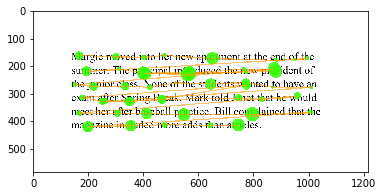

In [4]:
# draw original correct fixations

correction.draw_fixation('synthetic_text.png', data['robot1'].copy())

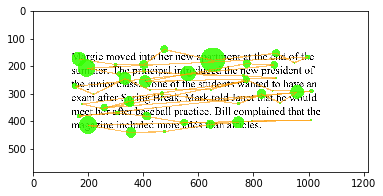

In [5]:
# generate noise over the correct trial

error_test = correction.error_noise(1, 30, 1, data['robot1'].copy())

# draw the trial with added error
correction.draw_fixation('synthetic_text.png', error_test)

0.98


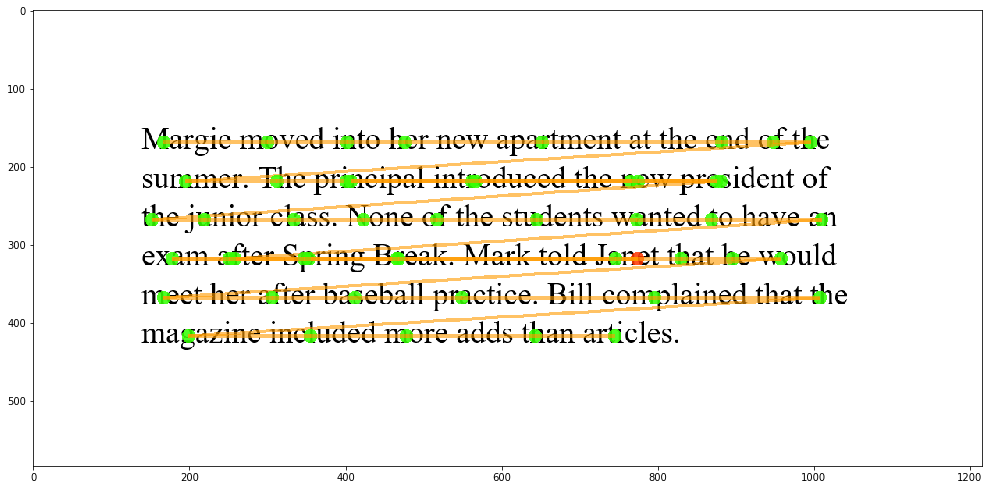

In [6]:
# find the center of each word, we need this for warp algorithm
word_centers = correction.find_word_centers(aoi)
word_centers = np.array(word_centers.copy(), dtype=int)

# warp correction
np_array = np.array(error_test.copy(), dtype=int)
durations = np.delete(np_array, 0, 1)
durations = np.delete(durations, 0, 1)
np_array = np.delete(np_array, 2, 1)

# run warp
warp_correction = algo.warp(np_array, word_centers)

# this is a cool function that checks the quality of the correction
percentage, match_list = correction.correction_quality(aoi, data['robot1'].copy(), warp_correction)
print(percentage)

# this is a cool function that draws the correction in red if the algorithm made a mistake
correction.draw_correction('synthetic_text.png', warp_correction, match_list)

This concludes the example I wanted to show you of running an error generator, then correcting the data, then seeing how well the correction algorithm did.  You will need to repeat the same concept for a bunch of algorithms in the next section.

# Comparing algorithms with Noise error:

In this example, I show you one type of erro "Noise" you will implement all 5 types and add skipping to your assessment.  Also, the code below runs only 4 algorithms, you will add the remaining 6 algorithms to this assessment for each type of error. 

In [7]:
word_centers = correction.find_word_centers(aoi)
word_centers = np.array(word_centers.copy(), dtype=int)

In [8]:
duration_word_centers = correction.find_word_centers_and_duration(aois_with_tokens)
duration_word_centers = np.array(duration_word_centers.copy(), dtype=int)

In [9]:
import time

ct = lambda : int(time.time() * 1000)
class Timer():
    def __init__(self):
        self.past = 0
    
    def start(self):
        self.past = ct()
        
    def end(self):
        x = ct() - self.past
        return x

In [10]:
algorithms = ["attach", "chain", "cluster", "compare", "merge", "regress", "segment", "split", "stretch", "warp"]
import datetime
def run_error_on_algorithms(error_function, data, num_runs = 1, compare_self = False):
    '''
    
    error_function should be a callable with the signature (error_probability, data)
    - error_probability is range(0,11) (ie, 0 through 10)
    - data is the ground truth data for noise to be added on
    - robot_index is the string key
    '''
    
    results = {alg:[[],[],[],[],[],[],[],[],[],[],[]] for alg in algorithms}

    word_center_algo = ["compare", "warp"]

    for robot_index in range(num_runs):
        print(datetime.datetime.now(), f" starting run {robot_index} out of {num_runs}")
        robot_str = 'robot' + str(robot_index)
        for error_probability in range(0, 11):

            error_test = error_function(error_probability, data, robot_str)

            for alg in algorithms:
                error_test_copy = np.array(error_test.copy())
                if alg in word_center_algo:
                    model_guess = getattr(algo, alg)(error_test_copy[:,:2], word_centers)
                else:
                    model_guess = getattr(algo, alg)(error_test_copy, line_ys)

                compare_to = data[robot_str].copy() if not compare_self else error_test
                percentage, match_list = correction.correction_quality(aoi, compare_to, model_guess)
                #print(percentage, match_list)
                results[alg][error_probability].append(percentage)
                #print(alg, error_probability)

            if percentage < 1:
                #correction.draw_correction('synthetic_text.png', warp_correction, match_list)
                print("robot:", robot_index, "    error probability:", error_probability)

    return results

import matplotlib.pyplot as plt


In [11]:
import statistics

def mean_error_group(results):
    new_list = []
    
    for result in results:
        new_list.append(statistics.mean(result))
        
    return new_list

In [12]:
def plot_results(mean_results):
    f, ax = plt.subplots()
    markers = ".ov^<>1234"
    for i, alg in enumerate(algorithms):
        ax.plot(mean_results[alg], marker=markers[i]) # color='Black', linewidth=1, marker='^')

    ax.legend(algorithms)
    ax.set_ylabel('accuracy')
    ax.set_xlabel('noise')

    x_ticks_labels = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']
    ax.set_xticks(range(0, 11))

    return ax


In [13]:
def e2e_error(error_name, errof_f, data, compare_self):
    
    results = run_error_on_algorithms(errof_f, data, num_runs = 10, compare_self = compare_self)
    print(results)
    mean_results = {alg:mean_error_group(results[alg]) for alg in algorithms}
    plot = plot_results(mean_results)

    for alg in algorithms:
        print(f"[{error_name}] mean {alg}:", statistics.mean(mean_results[alg]))
        
    return {"error_name": error_name, "plot": plot, "results": results, "mean_results": mean_results}

In [14]:
import correction

def noise_error(prob, data, robot_str):
    x = correction.error_noise(prob/10, prob * 4, prob/10, data[robot_str].copy())
    return x

def slope_error(prob, data, robot_str):
    x = correction.error_slope(prob/100, data[robot_str].copy())
    return x

def shift_error(prob, data, robot_str):
    x = correction.error_shift(prob/50, data[robot_str].copy())
    return x

def withinl_error(prob, data, robot_str):
    x = correction.error_withinline(prob/40, data[robot_str].copy())
    return x

def betweenl_error(prob, data, robot_str):
    x = correction.error_betweenline(prob/40, data[robot_str].copy())
    return x

In [15]:
def example_error_data(error_f):
    for error_probability in [0, 5, 10]:
        error_data = error_f(error_probability, data, "robot0")
        correction.draw_fixation('synthetic_text.png', error_data)

In [16]:
data

{'robot0': [[177.16666666666666, 175.0, 300],
  [300.5, 168.0, 250],
  [395.1666666666667, 172.0, 200],
  [472.5, 171.0, 150],
  [546.5, 160.0, 150],
  [638.1666666666666, 161.0, 450],
  [764.5, 167.0, 100],
  [809.1666666666666, 178.0, 150],
  [873.5, 167.0, 150],
  [998.1666666666666, 176.0, 150],
  [190.16666666666666, 225.0, 350],
  [416.5, 228.0, 450],
  [577.8333333333334, 223.0, 500],
  [775.1666666666666, 210.0, 150],
  [876.5, 217.0, 450],
  [1004.5, 214.0, 100],
  [148.16666666666666, 265.0, 150],
  [226.5, 271.0, 300],
  [342.1666666666667, 270.0, 300],
  [427.1666666666667, 264.0, 200],
  [502.5, 270.0, 100],
  [341.1666666666667, 265.0, 300],
  [428.1666666666667, 263.0, 200],
  [501.5, 272.0, 100],
  [558.1666666666666, 265.0, 150],
  [653.1666666666666, 270.0, 400],
  [226.5, 261.0, 300],
  [329.1666666666667, 276.0, 300],
  [507.5, 276.0, 100],
  [638.1666666666666, 268.0, 400],
  [788.8333333333334, 264.0, 300],
  [940.1666666666666, 266.0, 200],
  [997.5, 262.0, 100],

NOISE


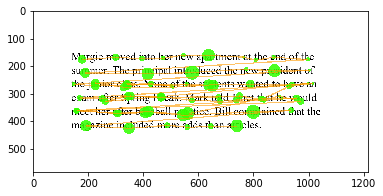

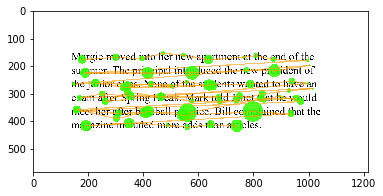

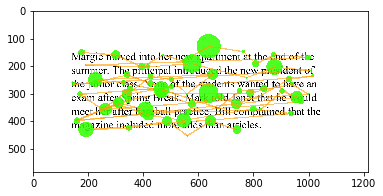

In [17]:
print("NOISE")
example_error_data(noise_error)

SLOPE
0.0
0.05
0.1


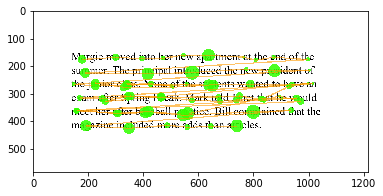

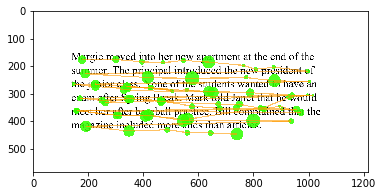

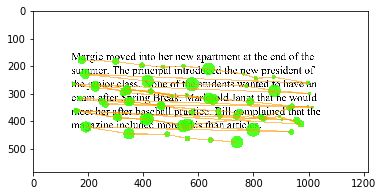

In [18]:
print("SLOPE")
example_error_data(slope_error)

SHIFT


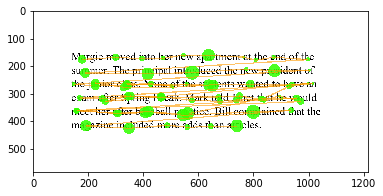

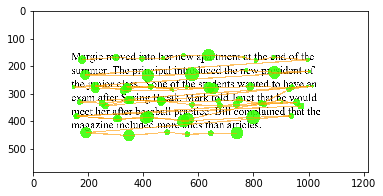

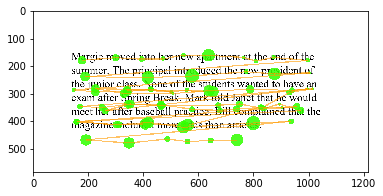

In [19]:
print("SHIFT")
example_error_data(shift_error)

WITHINLINE


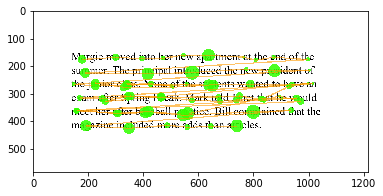

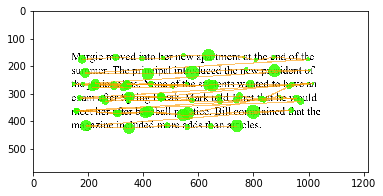

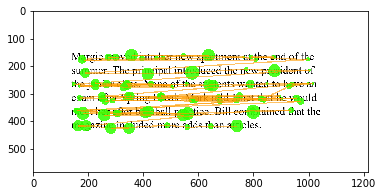

In [20]:
print("WITHINLINE")
example_error_data(withinl_error)

BETWEENLINE


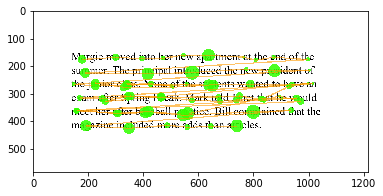

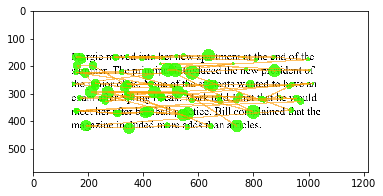

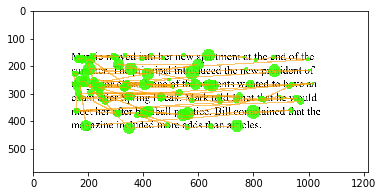

In [21]:
print("BETWEENLINE")
example_error_data(betweenl_error)

In [22]:
if False:
    import multiprocessing as mp


    p1 = mp.Process(target=e2e_error, args=("noise", noise_error, data))
    p2 = mp.Process(target=e2e_error, args=("slope", slope_error, data))
    p3 = mp.Process(target=e2e_error, args=("shift", shift_error, data))
    p4 = mp.Process(target=e2e_error, args=("withinline", withinl_error, data))
    p5 = mp.Process(target=e2e_error, args=("betweenline", betweenl_error, data))

    p1.start()
    p2.start()
    p3.start()
    p4.start()
    p5.start()

    p1.join()
    p2.join()
    p3.join()
    p4.join()
    p5.join()



# Noise

2023-02-20 13:37:45.082194  starting run 0 out of 10
robot: 0     error probability: 0
robot: 0     error probability: 1
robot: 0     error probability: 2
robot: 0     error probability: 3
robot: 0     error probability: 4
robot: 0     error probability: 5
robot: 0     error probability: 6
robot: 0     error probability: 7
robot: 0     error probability: 8
robot: 0     error probability: 9
robot: 0     error probability: 10
2023-02-20 13:38:36.705440  starting run 1 out of 10
robot: 1     error probability: 0
robot: 1     error probability: 1
robot: 1     error probability: 2
robot: 1     error probability: 3
robot: 1     error probability: 4
robot: 1     error probability: 5
robot: 1     error probability: 6
robot: 1     error probability: 7
robot: 1     error probability: 8
robot: 1     error probability: 9
robot: 1     error probability: 10
2023-02-20 13:39:12.670193  starting run 2 out of 10
robot: 2     error probability: 0
robot: 2     error probability: 1
robot: 2     error prob

<ipython-input-10-fce552de3734>:28: RankWarning: Polyfit may be poorly conditioned
  model_guess = getattr(algo, alg)(error_test_copy, line_ys)


robot: 2     error probability: 9
robot: 2     error probability: 10
2023-02-20 13:39:50.221908  starting run 3 out of 10
2023-02-20 13:40:21.844474  starting run 4 out of 10
2023-02-20 13:40:51.060696  starting run 5 out of 10


<ipython-input-10-fce552de3734>:28: RankWarning: Polyfit may be poorly conditioned
  model_guess = getattr(algo, alg)(error_test_copy, line_ys)


2023-02-20 13:41:26.976639  starting run 6 out of 10
robot: 6     error probability: 0
robot: 6     error probability: 1
robot: 6     error probability: 2
robot: 6     error probability: 3
robot: 6     error probability: 4
robot: 6     error probability: 5
robot: 6     error probability: 6
robot: 6     error probability: 7
robot: 6     error probability: 8
robot: 6     error probability: 9
robot: 6     error probability: 10
2023-02-20 13:42:10.196125  starting run 7 out of 10
robot: 7     error probability: 0
robot: 7     error probability: 1
robot: 7     error probability: 2
robot: 7     error probability: 3
robot: 7     error probability: 4
robot: 7     error probability: 5
robot: 7     error probability: 6
robot: 7     error probability: 7
robot: 7     error probability: 8
robot: 7     error probability: 9
robot: 7     error probability: 10
2023-02-20 13:42:47.767503  starting run 8 out of 10
robot: 8     error probability: 0
robot: 8     error probability: 1
robot: 8     error prob

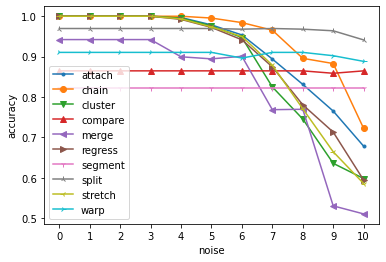

In [23]:
noise_r = e2e_error("noise", noise_error, data, compare_self = False)

# Slope

2023-02-20 15:17:24.057017  starting run 0 out of 10
0.0
robot: 0     error probability: 0
0.01
robot: 0     error probability: 1
0.02
robot: 0     error probability: 2
0.03
robot: 0     error probability: 3
0.04
robot: 0     error probability: 4
0.05
robot: 0     error probability: 5
0.06
robot: 0     error probability: 6
0.07
robot: 0     error probability: 7
0.08
robot: 0     error probability: 8
0.09
robot: 0     error probability: 9
0.1
robot: 0     error probability: 10
2023-02-20 15:17:58.812404  starting run 1 out of 10
0.0
robot: 1     error probability: 0
0.01
robot: 1     error probability: 1
0.02
robot: 1     error probability: 2
0.03
robot: 1     error probability: 3
0.04
robot: 1     error probability: 4
0.05
robot: 1     error probability: 5
0.06
robot: 1     error probability: 6
0.07
robot: 1     error probability: 7
0.08
robot: 1     error probability: 8
0.09
robot: 1     error probability: 9
0.1
robot: 1     error probability: 10
2023-02-20 15:18:24.222020  starting r

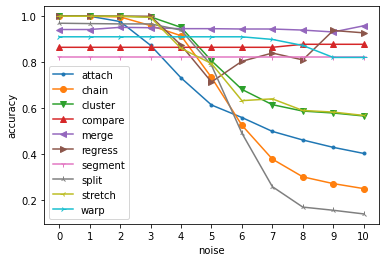

In [30]:
slope_r = e2e_error("slope", slope_error, data, compare_self = False)

# Shift

robot: 0     error probability: 0
robot: 0     error probability: 1
robot: 0     error probability: 2
robot: 0     error probability: 3
robot: 0     error probability: 4
robot: 0     error probability: 5
robot: 0     error probability: 6
robot: 0     error probability: 7
robot: 0     error probability: 8
robot: 0     error probability: 9
robot: 0     error probability: 10
2023-02-20 13:56:03.768151  starting run 1 out of 10
robot: 1     error probability: 0
robot: 1     error probability: 1
robot: 1     error probability: 2
robot: 1     error probability: 3
robot: 1     error probability: 4
robot: 1     error probability: 5
robot: 1     error probability: 6
robot: 1     error probability: 7
robot: 1     error probability: 8
robot: 1     error probability: 9
robot: 1     error probability: 10
2023-02-20 13:56:36.802404  starting run 2 out of 10
robot: 2     error probability: 0
robot: 2     error probability: 1
robot: 2     error probability: 2
robot: 2     error probability: 3
robot: 2

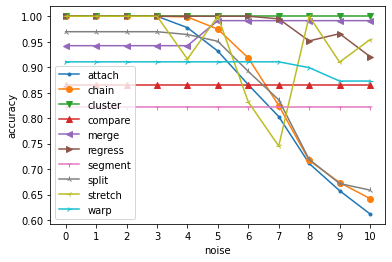

In [25]:
shift_r = e2e_error("shift", shift_error, data, compare_self = False)

# Within-line

2023-02-20 15:10:57.430866  starting run 0 out of 10
robot: 0     error probability: 0
robot: 0     error probability: 1
robot: 0     error probability: 2
robot: 0     error probability: 3
robot: 0     error probability: 4
robot: 0     error probability: 5
robot: 0     error probability: 6
robot: 0     error probability: 7
robot: 0     error probability: 8
robot: 0     error probability: 9
robot: 0     error probability: 10
2023-02-20 15:12:30.108657  starting run 1 out of 10
robot: 1     error probability: 0
robot: 1     error probability: 1
robot: 1     error probability: 2
robot: 1     error probability: 3
robot: 1     error probability: 4
robot: 1     error probability: 5
robot: 1     error probability: 6
robot: 1     error probability: 7
robot: 1     error probability: 8
robot: 1     error probability: 9
robot: 1     error probability: 10
2023-02-20 15:13:02.326436  starting run 2 out of 10
robot: 2     error probability: 0
robot: 2     error probability: 1
robot: 2     error prob

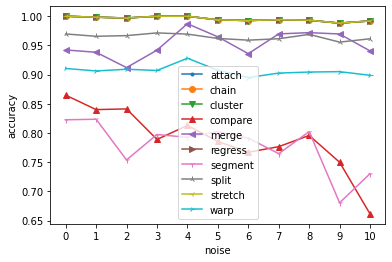

In [29]:
within_r = e2e_error("withinline", withinl_error, data, compare_self = True)

In [ ]:
def demo():
    withinl_error_data = withinl_error(0.6, data, "robot0")
    corrected_data = algo.attach(np.array(withinl_error_data), line_ys)#algo.warp(np_array, word_centers)

    # this is a cool function that checks the quality of the correction
    percentage, match_list = correction.correction_quality(aoi, withinl_error_data, corrected_data)
    print(percentage)
    
    print(corrected_data.shape, len(match_list))

    # this is a cool function that draws the correction in red if the algorithm made a mistake
    correction.draw_correction('synthetic_text.png', corrected_data, match_list)
    
demo()

# Between-line

robot: 0     error probability: 0
robot: 0     error probability: 1
robot: 0     error probability: 2
robot: 0     error probability: 3
robot: 0     error probability: 4
robot: 0     error probability: 5
robot: 0     error probability: 6
robot: 0     error probability: 7
robot: 0     error probability: 8
robot: 0     error probability: 9
robot: 0     error probability: 10
2023-02-20 14:08:59.292309  starting run 1 out of 10
robot: 1     error probability: 0
robot: 1     error probability: 1
robot: 1     error probability: 2
robot: 1     error probability: 3
robot: 1     error probability: 4
robot: 1     error probability: 5
robot: 1     error probability: 6
robot: 1     error probability: 7
robot: 1     error probability: 8
robot: 1     error probability: 9
robot: 1     error probability: 10
2023-02-20 14:09:46.881931  starting run 2 out of 10
robot: 2     error probability: 0
robot: 2     error probability: 1
robot: 2     error probability: 2
robot: 2     error probability: 3
robot: 2

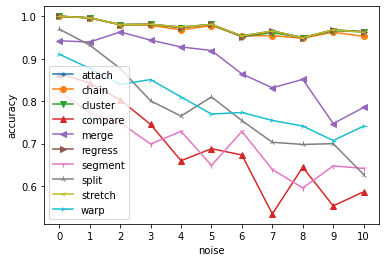

In [28]:
between_r = e2e_error("betweenline", betweenl_error, data, compare_self = True)